Part 3 of the assigment.

1. Selecting and plotting a signal in it's time and frequency domain. The first signal is  time-limited and the second one is band-limited. 

In [193]:
#install missing libraries
! pip install --upgrade numpy
! pip install --upgrade matplotlib
! pip install scikit-dsp-comm
! pip install komm

In [194]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')
import warnings
warnings.filterwarnings('ignore')
import sympy as sp
sp.init_printing() 
from matplotlib import style
style.use('bmh')
plt.rcParams['figure.figsize'] = 16, 6
import komm
import scipy.fftpack as fftpack
import scipy.special

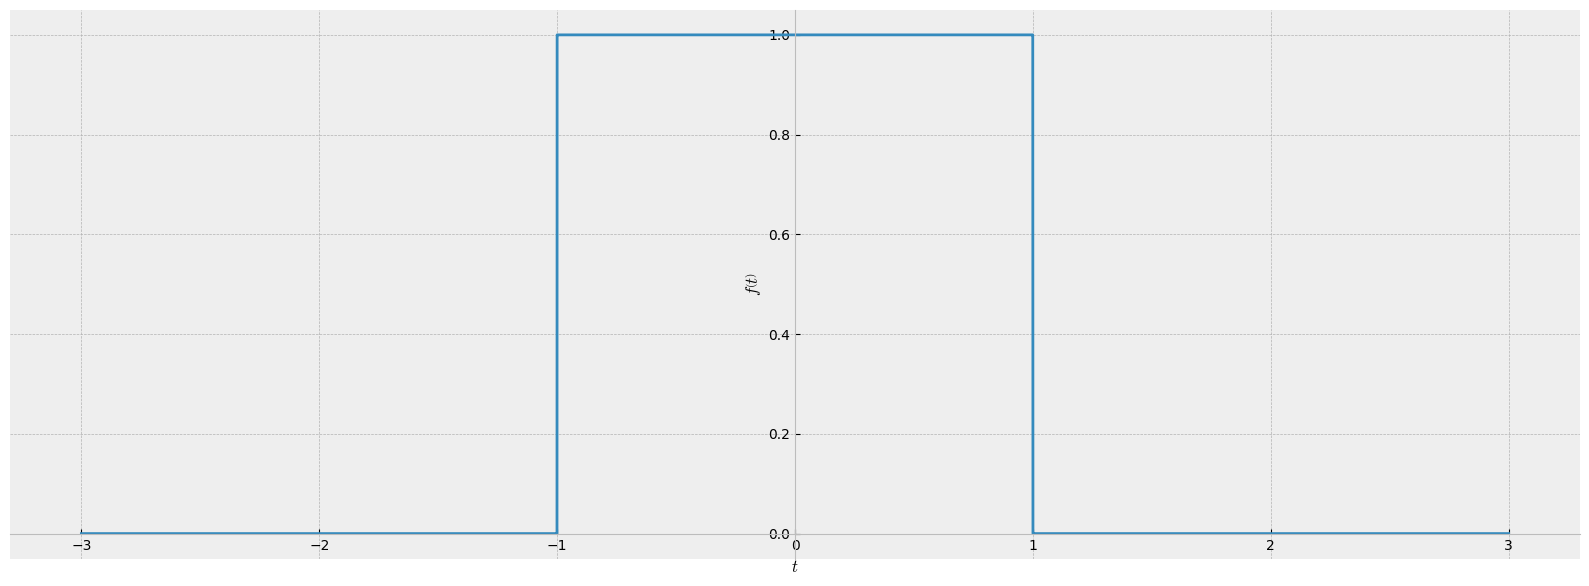

In [195]:
# a) Timelimited pulse in time domain constructed by two heaviside functions
t = sp.symbols('t')
sp.plot(sp.Heaviside(t+1) - sp.Heaviside(t-1), (t, -3, 3))

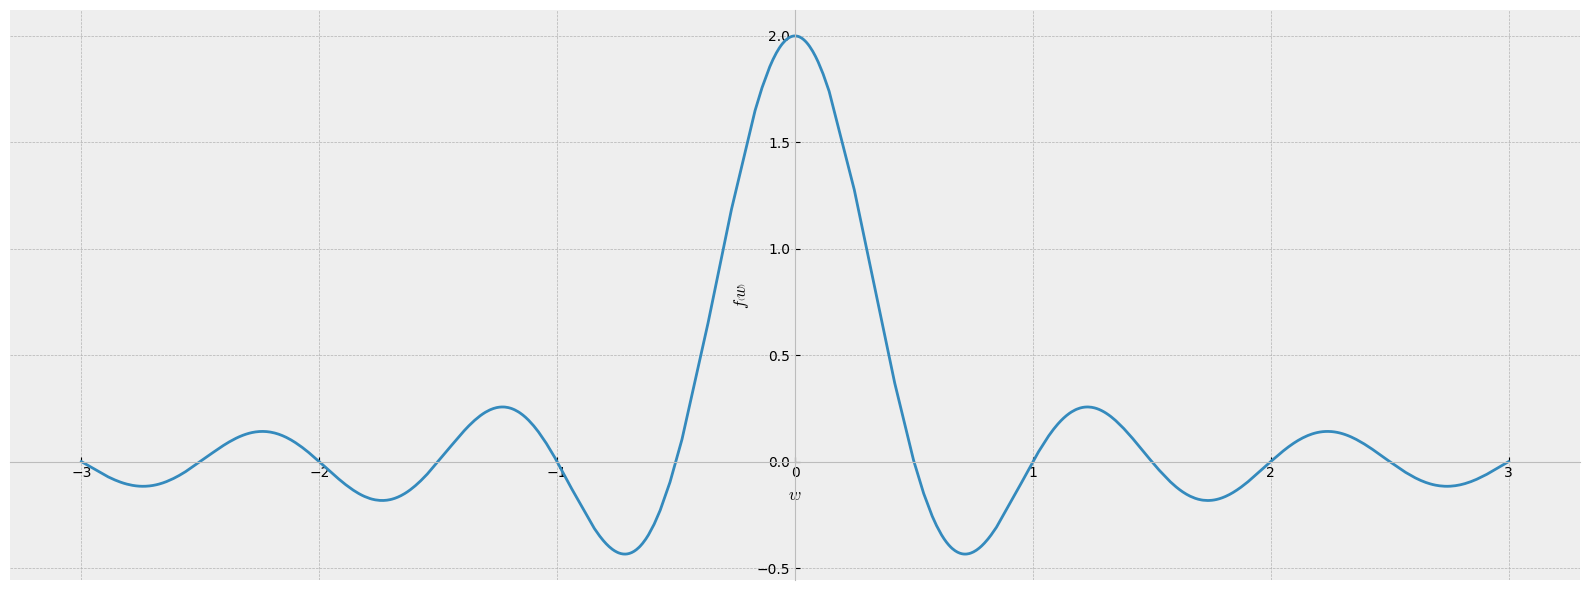

In [196]:
# a) Timelimited pulse in freaquency domain constructed by two heaviside functions

w = sp.symbols('w')
sp.plot(sp.fourier_transform(sp.Heaviside(t+1) - sp.Heaviside(t-1), t, w),(w,-3,3))

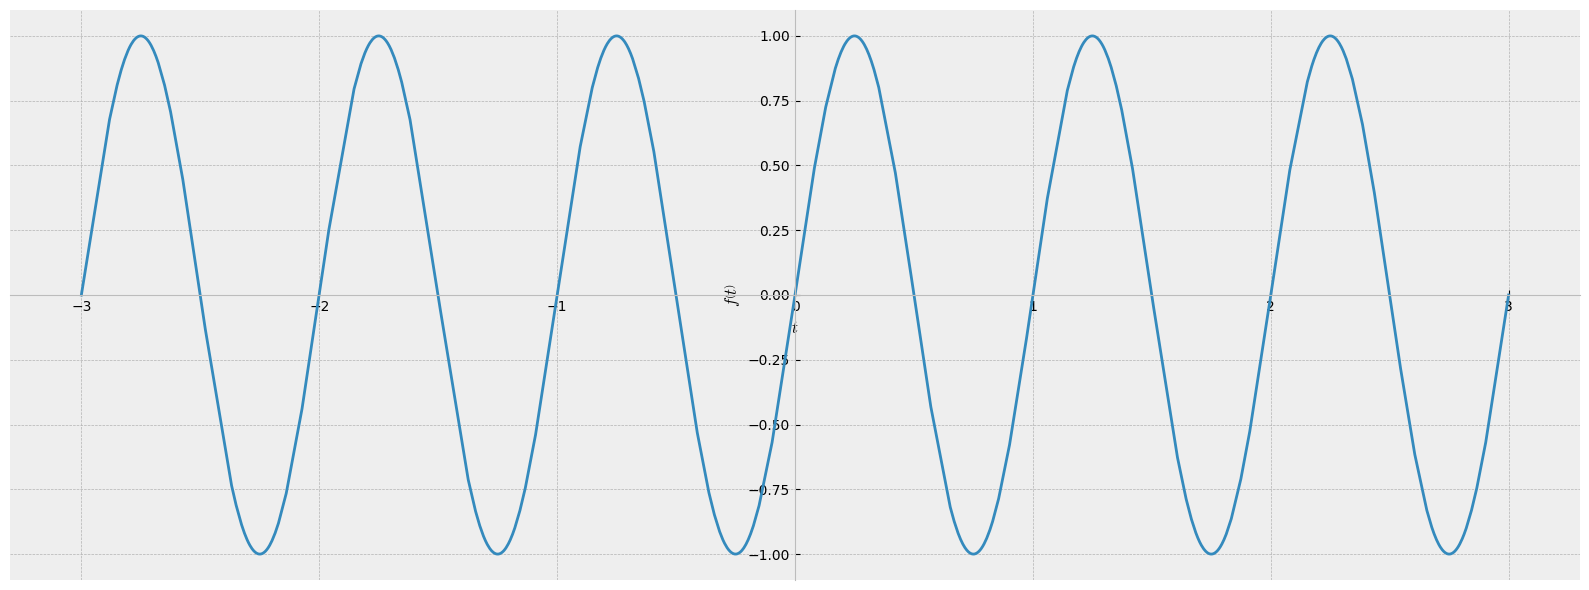

In [197]:
# b) band limited signal in time domain constructed of sin function

sp.plot(sp.sin(2*t*sp.pi), (t, -3, 3))

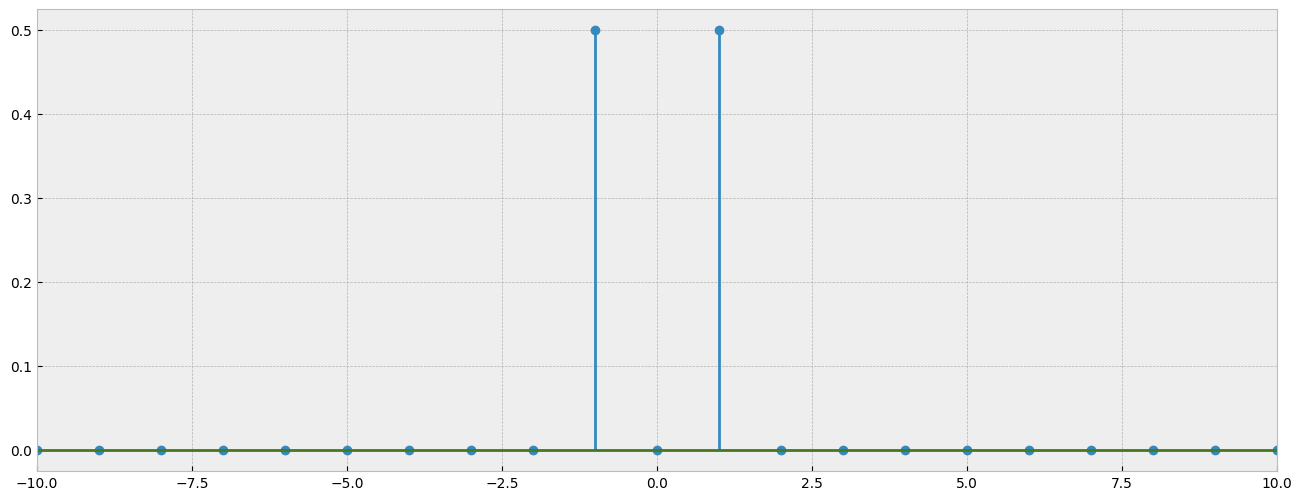

In [198]:
# b) band limited signal in frequency domain constructed of sin function
# Could not use the same sp.fourier_transform function as previously since with the sp.sin(2*t*sp.pi) the result is 0. I guess this is a bug with the library. More on here: https://groups.google.com/g/sympy/c/e8GiLUsr9eo
# Code is heavily inspired by the second week's notebook on the course.
m = sp.sin(2*t*sp.pi)
m_converted = sp.lambdify(t, m, "numpy")
fig, ax = plt.subplots()
tp = np.linspace(0, 1, 10_000)
x = m_converted(tp)
X = fftpack.fft(x) / 10_000

freqs = fftpack.fftfreq(len(x)) * 10_000 
ax.stem(freqs, np.abs(X))
ax.set_xlim(-10, 10)

2. Comparing the 2-PAM, 4-PAM, 4-QAM, 16-QAM, 64-QAM, 4-PSK, 8-PSK and 16-PSK in an AWGN channel. 

Need to calculate the symbol error function for PAM.
1. Pe ~= Ndmin*Q*(sqrt(np*Eb/2N0)), where np = (dmin)^2/Eb

- We know that dmin = sqrt(12*Es/(M^2-1)) for PAM 
- M = 2^k
- Ndmin = 2
- Es = 1
- Eb = Es/log2(M) = 1/log2(M) = 1/log2(2^k)= 1/k
- np = sqrt(12*Es/(M^2-1))^2/Eb = 12/((M^2-1)/log2(M)) = 12k/(M^2-1)
- Pe = 2*Q*(sqrt(np*Eb/2*N0)) = 2Q*(sqrt(12kEb/2*(M^2-1)N0)) = 2Q(sqrt(6kEb/(M^2-1)N0)) = 2Q(sqrt(6/(M^2-1)*N0))

2. The same calculations for QAM
- dmin = sqrt(6Es/(M-1))
- M = 2^k
- Ndmin = 4
- np = sqrt(6Es/(M-1))^2/(1/k)
- Pe = 4Q(sqrt(np*Eb/2N0)) = 4Q(sqrt(6k*1/k)/2*(M-1)*N0) = 4Q(sqrt(3/(M-1N0)))

3. The same calculations for PSK
- dmin = sqrt(Es)*(2*pi/M)
- Ndmin = 2
- np = sqrt(2Es(1-cos(2*pi/M)))^2/Eb = 2(1-cos(2*pi/M))k
- Pe = 2Q(sqrt((1-cos(2*pi/m))/N0))

In [199]:
# Creating the AWGN
awgn = komm.AWGNChannel()
noise_power_db = np.arange(-20, 2, 0.05)
noise_power = 10**(noise_power_db/10)

In [200]:
def Q(x):
    return 1/2*scipy.special.erfc(x/np.sqrt(2))

In [201]:
# 2-PAM
M = 2
ep_2pam = 2*Q(np.sqrt(6/((M**2-1)*noise_power)))
# 4-Pam
M = 4
ep_4pam = 2*Q(np.sqrt(6/((M**2-1)*noise_power)))
##
# 4-QAM
M = 4
ep_4qam = 4*Q(np.sqrt(3/((M-1)*noise_power)))
# 16-QAM
M = 16
ep_16qam = 4*Q(np.sqrt(3/((M-1)*noise_power)))
# 64-QAM
M = 64
ep_64qam = 4*Q(np.sqrt(3/((M-1)*noise_power)))
# 4-PSK
M = 4
ep_4psk = 2*Q(np.sqrt((1 - np.cos(2 * np.pi / M)) / noise_power ))
# 8-PSK
M = 8
ep_8psk = 2*Q(np.sqrt((1 - np.cos(2 * np.pi / M)) / noise_power ))
# 16-PSK
M = 16
ep_16psk = 2*Q(np.sqrt((1 - np.cos(2 * np.pi / M)) / noise_power ))

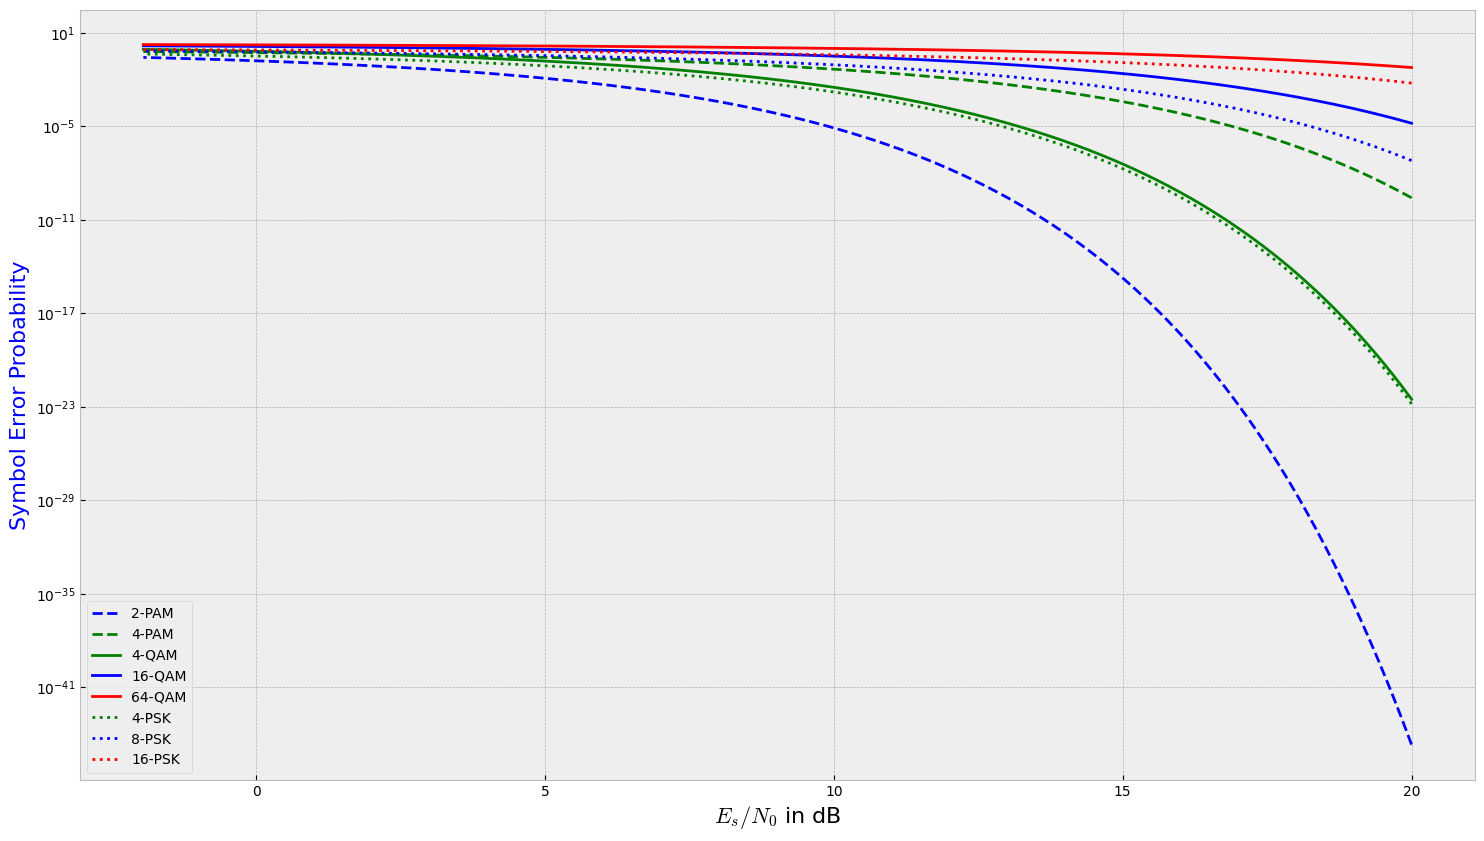

In [202]:
plt.figure(1,figsize=(18,10))
plt.semilogy(10 * np.log10(1/noise_power), ep_2pam,'--b',label='2-PAM')
plt.semilogy(10 * np.log10(1/noise_power), ep_4pam,'--g',label='4-PAM')
#
plt.semilogy(10 * np.log10(1/noise_power), ep_4qam,'g',label='4-QAM')
plt.semilogy(10 * np.log10(1/noise_power), ep_16qam,'b',label='16-QAM')
plt.semilogy(10 * np.log10(1/noise_power), ep_64qam,'r',label='64-QAM')
#
plt.semilogy(10 * np.log10(1/noise_power), ep_4psk,':g',label='4-PSK')
plt.semilogy(10 * np.log10(1/noise_power), ep_8psk,':b',label='8-PSK')
plt.semilogy(10 * np.log10(1/noise_power), ep_16psk,':r',label='16-PSK')
#
plt.xlabel('$E_s/N_0$ in dB',fontsize=16)
plt.ylabel('Symbol Error Probability', color='b',fontsize=16)
plt.legend()

b) Comparing these modulation methods in relation to spectral efficiency and bit error probability.

In [221]:
# Spectral efficiency
# 2-PAM
order = 2
base_amplitude = 1
modulation = komm.PAModulation(order, base_amplitude)
awgn.signal_power_2pam  = modulation.energy_per_symbol
awgn.snr_2pam  = awgn.signal_power_2pam  / noise_power/2
# 4-PAM
order = 4
modulation = komm.PAModulation(order, base_amplitude)
awgn.signal_power_4pam  = modulation.energy_per_symbol
awgn.snr_4pam  = awgn.signal_power_4pam  / noise_power/2
# 4-QAM
order = 4
modulation = komm.QAModulation(order, base_amplitude)
awgn.signal_power_4qam  = modulation.energy_per_symbol
awgn.snr_4qam  = awgn.signal_power_4qam  / noise_power
# 16-QAM
order = 16
modulation = komm.QAModulation(order, base_amplitude)
awgn.signal_power_16qam  = modulation.energy_per_symbol
awgn.snr_16qam  = awgn.signal_power_16qam  / noise_power
# 64-QAM
order = 64
modulation = komm.QAModulation(order, base_amplitude)
awgn.signal_power_64qam  = modulation.energy_per_symbol
awgn.snr_64qam  = awgn.signal_power_64qam  / noise_power
# 4-PSK
order = 4
modulation = komm.PSKModulation(order, base_amplitude)
awgn.signal_power_4psk  = modulation.energy_per_symbol
awgn.snr_4psk  = awgn.signal_power_4psk  / noise_power
# 8-PSK
order = 8
modulation = komm.PSKModulation(order, base_amplitude)
awgn.signal_power_8psk  = modulation.energy_per_symbol
awgn.snr_8psk  = awgn.signal_power_8psk  / noise_power
# 16-PSK
order = 16
modulation = komm.PSKModulation(order, base_amplitude)
awgn.signal_power_16psk  = modulation.energy_per_symbol
awgn.snr_16psk  = awgn.signal_power_16psk  / noise_power

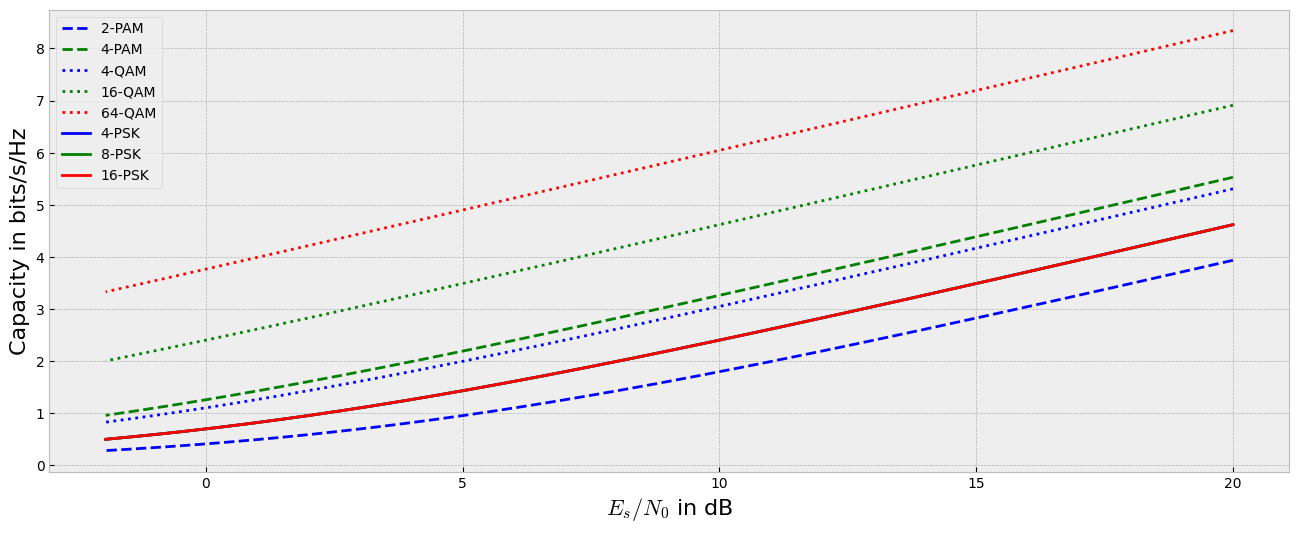

In [222]:
plt.plot(10 * np.log10(1/noise_power), np.log(1+awgn.snr_2pam),'--b',label='2-PAM')
plt.plot(10 * np.log10(1/noise_power), np.log(1+awgn.snr_4pam),'--g',label='4-PAM')
plt.plot(10 * np.log10(1/noise_power), np.log(1+awgn.snr_4qam),':b',label='4-QAM')
plt.plot(10 * np.log10(1/noise_power), np.log(1+awgn.snr_16qam),':g',label='16-QAM')
plt.plot(10 * np.log10(1/noise_power), np.log(1+awgn.snr_64qam),':r',label='64-QAM')
plt.plot(10 * np.log10(1/noise_power), np.log(1+awgn.snr_4psk),'b',label='4-PSK')
plt.plot(10 * np.log10(1/noise_power), np.log(1+awgn.snr_8psk),'g',label='8-PSK')
plt.plot(10 * np.log10(1/noise_power), np.log(1+awgn.snr_16psk),'r',label='16-PSK')
plt.xlabel('$E_s/N_0$ in dB',fontsize=16)
plt.ylabel('Capacity in bits/s/Hz', color='k',fontsize=16)
plt.legend()

The bit error probabilities
- Pb = Q(sqrt(np*Eb/2N0)), so we can use the functions defined earlier

In [205]:
# Bit error probability
# 2-PAM
M = 2
eb_2pam = Q(np.sqrt(6/((M**2-1)*noise_power)))
# 4-Pam
M = 4
eb_4pam = Q(np.sqrt(6/((M**2-1)*noise_power)))
##
# 4-QAM
M = 4
eb_4qam = Q(np.sqrt(3/((M-1)*noise_power)))
# 16-QAM
M = 16
eb_16qam = Q(np.sqrt(3/((M-1)*noise_power)))
# 64-QAM
M = 64
eb_64qam = Q(np.sqrt(3/((M-1)*noise_power)))
# 4-PSK
M = 4
eb_4psk = Q(np.sqrt((1 - np.cos(2 * np.pi / M)) / noise_power ))
# 8-PSK
M = 8
eb_8psk = Q(np.sqrt((1 - np.cos(2 * np.pi / M)) / noise_power ))
# 16-PSK
M = 16
eb_16psk = Q(np.sqrt((1 - np.cos(2 * np.pi / M)) / noise_power ))

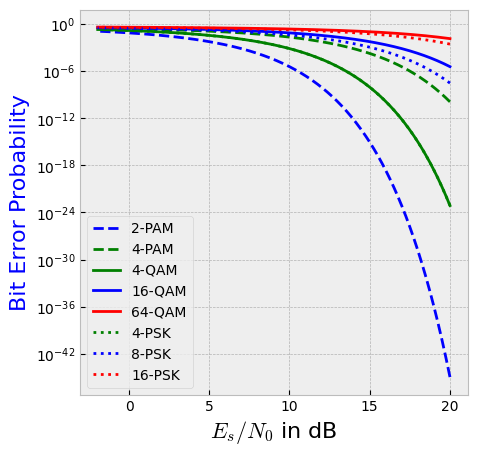

In [ ]:
plt.figure(1,figsize=(5,5))
plt.semilogy(10 * np.log10(1/noise_power), eb_2pam,'--b',label='2-PAM')
plt.semilogy(10 * np.log10(1/noise_power), eb_4pam,'--g',label='4-PAM')
#
plt.semilogy(10 * np.log10(1/noise_power), eb_4qam,'g',label='4-QAM')
plt.semilogy(10 * np.log10(1/noise_power), eb_16qam,'b',label='16-QAM')
plt.semilogy(10 * np.log10(1/noise_power), eb_64qam,'r',label='64-QAM')
#
plt.semilogy(10 * np.log10(1/noise_power), eb_4psk,':g',label='4-PSK')
plt.semilogy(10 * np.log10(1/noise_power), eb_8psk,':b',label='8-PSK')
plt.semilogy(10 * np.log10(1/noise_power), eb_16psk,':r',label='16-PSK')
#
plt.xlabel('$E_s/N_0$ in dB',fontsize=16)
plt.ylabel('Bit Error Probability', color='b',fontsize=16)
plt.legend()

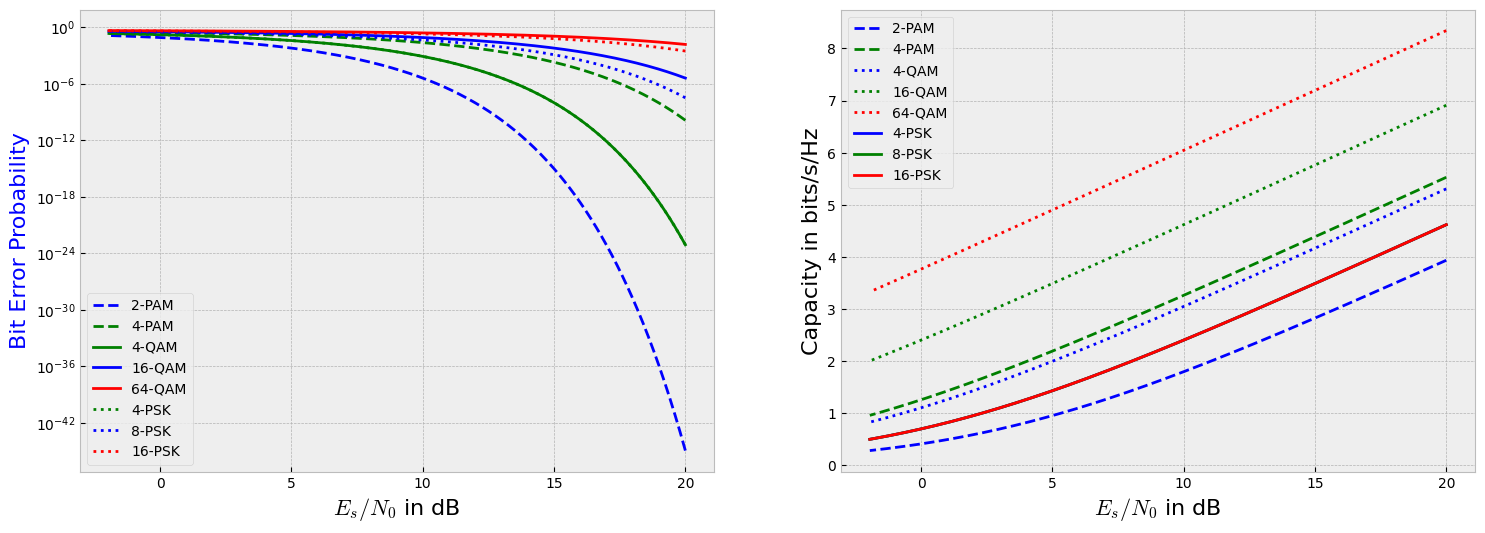

In [223]:
#Plotting the figures next to each other
plt.figure(1,figsize=(18,6))
plt.subplot(121)
plt.semilogy(10 * np.log10(1/noise_power), eb_2pam,'--b',label='2-PAM')
plt.semilogy(10 * np.log10(1/noise_power), eb_4pam,'--g',label='4-PAM')
#
plt.semilogy(10 * np.log10(1/noise_power), eb_4qam,'g',label='4-QAM')
plt.semilogy(10 * np.log10(1/noise_power), eb_16qam,'b',label='16-QAM')
plt.semilogy(10 * np.log10(1/noise_power), eb_64qam,'r',label='64-QAM')
#
plt.semilogy(10 * np.log10(1/noise_power), eb_4psk,':g',label='4-PSK')
plt.semilogy(10 * np.log10(1/noise_power), eb_8psk,':b',label='8-PSK')
plt.semilogy(10 * np.log10(1/noise_power), eb_16psk,':r',label='16-PSK')
#
plt.xlabel('$E_s/N_0$ in dB',fontsize=16)
plt.ylabel('Bit Error Probability', color='b',fontsize=16)
plt.legend()

plt.subplot(122)
plt.plot(10 * np.log10(1/noise_power), np.log(1+awgn.snr_2pam),'--b',label='2-PAM')
plt.plot(10 * np.log10(1/noise_power), np.log(1+awgn.snr_4pam),'--g',label='4-PAM')
plt.plot(10 * np.log10(1/noise_power), np.log(1+awgn.snr_4qam),':b',label='4-QAM')
plt.plot(10 * np.log10(1/noise_power), np.log(1+awgn.snr_16qam),':g',label='16-QAM')
plt.plot(10 * np.log10(1/noise_power), np.log(1+awgn.snr_64qam),':r',label='64-QAM')
plt.plot(10 * np.log10(1/noise_power), np.log(1+awgn.snr_4psk),'b',label='4-PSK')
plt.plot(10 * np.log10(1/noise_power), np.log(1+awgn.snr_8psk),'g',label='8-PSK')
plt.plot(10 * np.log10(1/noise_power), np.log(1+awgn.snr_16psk),'r',label='16-PSK')
plt.xlabel('$E_s/N_0$ in dB',fontsize=16)
plt.ylabel('Capacity in bits/s/Hz', color='k',fontsize=16)
plt.legend()

As from the plots can be seen generally the better the modulation's capacity is the worse the bit error probability is. 

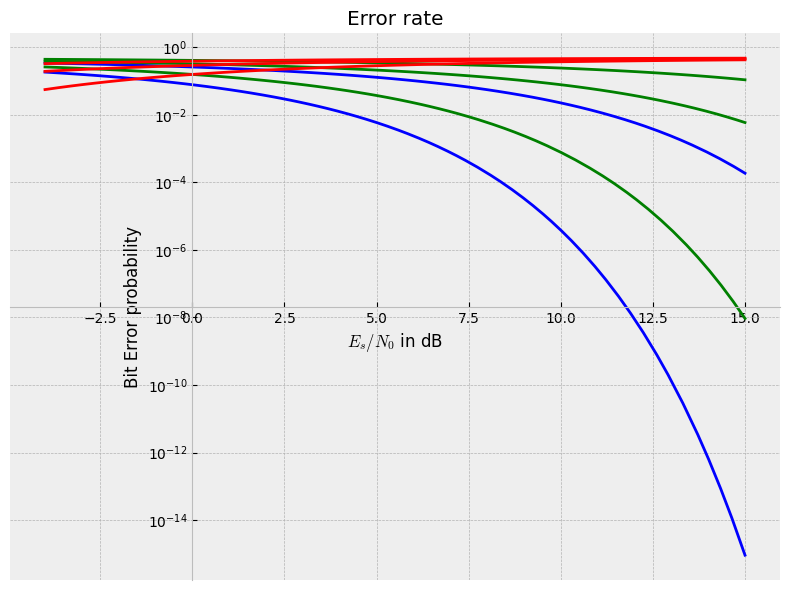

In [240]:
# Or using the different way of doing it that gives closer look at the smaller signal to noise ratio.

def Q(x):
    return sp.simplify(1/2 * sp.erfc(x/sp.sqrt(2)))

y = sp.Symbol("y")

plot_aux = sp.plot(
    sp.N(Q(sp.sqrt((6/((2**2-1))*10**(y/10))))), 
    sp.N(Q(sp.sqrt((6/((4**2-1))*10**(y/10))))),
    sp.N(Q(sp.sqrt((3/((4-1))*10**(y/10))))),
    sp.N(Q(sp.sqrt((3/((16-1))*10**(y/10))))),
    sp.N(Q(sp.sqrt((3/((64-1))*10**(y/10))))),
    sp.N(Q(sp.sqrt((1 - sp.cos(2 * sp.pi / 4)) / 10**(y/10) ))),
    sp.N(Q(sp.sqrt((1 - sp.cos(2 * sp.pi / 8)) / 10**(y/10) ))),
    sp.N(Q(sp.sqrt((1 - sp.cos(2 * sp.pi / 16)) / 10**(y/10) ))),
    (y,-4,15),
    xlabel='$E_s/N_0$ in dB',
    ylabel='Bit Error probability', 
    yscale= 'log', 
    title='Error rate',
    show=False)
plot_aux[0].line_color = 'b'
plot_aux[1].line_color = 'b'
plot_aux[2].line_color = 'g'
plot_aux[3].line_color = 'g'
plot_aux[4].line_color = 'g'
plot_aux[5].line_color = 'r'
plot_aux[6].line_color = 'r'
plot_aux[7].line_color = 'r'
plot_aux.show()

c) AWGN channel capacity as a function of SNR

Text(0, 0.5, 'Channel capacity')

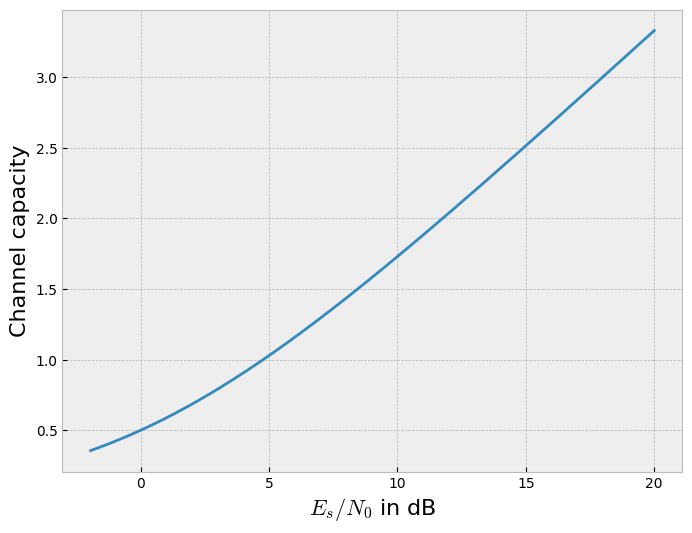

In [238]:
capacity_bsc = np.zeros(len(noise_power))
for i in range(len(noise_power)):
    capacity_bsc[i] = komm.AWGNChannel(snr=1/noise_power[i]).capacity()
plt.rcParams['figure.figsize'] = 8, 6
plt.plot(10 * np.log10(1/noise_power),capacity_bsc)

plt.xlabel('$E_s/N_0$ in dB',fontsize=16)
plt.ylabel('Channel capacity',fontsize=16)

d) The performance of the modulations could be improved by changing the signal's power. This would result in a lower Signal to Noise Ratio which would help the transmission go through without the probability of the noise affecting it too much. The best modulation method that mimizes the bit and symbol error's is the 2-PAM which can be seen in the figures performing the best regarding the errors. Unfortanetly it has the worst capacity of the modulation methods meaning that the transmission would be quite slow compared to other modulation methods. (The question was quite shady so I wasn't sure if the overall performance meaning all of the modulation methods were supposed to be considered or picked the best modulation method for the lowest error probability. So I provided the answer to both scenarios.) 

To know how good my solution is one can look at the bit error and symbol error graphs and note that 2-PAM provides the best performance in regards of error probability both in bit error and symbol error. And to know how much the power of the signal affects the error probabilities, one can select a modulation method and see how the signal power has influence over the error probability.

In [243]:
def Q(x):
    return 1/2*scipy.special.erfc(x/np.sqrt(2))

In [249]:
# 16-QAM
M = 16
ep_16qam = 4*Q(np.sqrt(3/((M-1)*noise_power)))
eb_16qam_improved = 4*Q(np.sqrt(3*10/((M-1)*noise_power)))


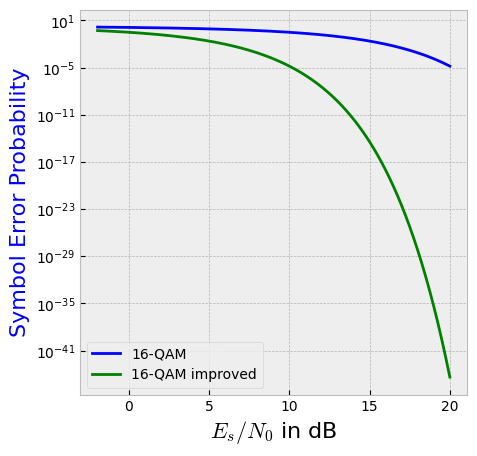

In [252]:
plt.figure(1,figsize=(5,5))

plt.semilogy(10 * np.log10(1/noise_power), ep_16qam,'b',label='16-QAM')
plt.semilogy(10 * np.log10(1/noise_power), eb_16qam_improved,'g',label='16-QAM improved')

plt.xlabel('$E_s/N_0$ in dB',fontsize=16)
plt.ylabel('Symbol Error Probability', color='b',fontsize=16)
plt.legend()

In the example above the energy per bit is increased 10x. The result can be seen in the figure that the improved version does infact get much lower error probability compared to the original modulation method. 